In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from pandas import Series, DataFrame, read_csv
from scipy.integrate import solve_ivp
from labellines import labelLine, labelLines
from dataclasses import dataclass

In [2]:
%matplotlib notebook

# mpl.rc("figure", dpi=300)
# mpl.rc("savefig", dpi=300)

In [3]:
g = 9.8 # m / s2
R = 8.314 # J / mol K

In [4]:
substance_data = read_csv("res/substance_data.csv").set_index("Species")

def _as_substance_series(a, **kwargs):
    return Series(a, index=substance_data.index, **kwargs)

substance_data

,Cp(J/molK),Hf(J/mol),MW(g/mol),p(kg/m3)
Species,,,,
GLY,221.18,-669600.0,92.0938,1260.00
AAC,159.80,-483520.0,60.0520,1050.00
W,75.38,-285830.0,18.0153,997.77
TAC,389.00,-1330800.0,218.2039,1160.00
DAC,340.98,-1120700.0,176.1672,1170.00
MAC,291.36,-903530.0,134.1305,1200.00


In [5]:
def _convert(df, src, dst, factor):
    _df = df
    if src in df.columns:
        _df[dst] = _df[src] * factor
    return _df

kinetic_parameters = read_csv("res/kinetic_parameters_bonet.csv").set_index("i")
kineitc_parameters = _convert(kinetic_parameters, "Ea(cal/mol)", "Ea(J/mol)", 4.184)
kinetic_parameters

,A(L/mols),Ea(J/mol)
i,,
1,6.9,31000.0
2,190.0,33000.0
3,6.8,31000.0
4,220.0,38000.0
5,2.4,34000.0
6,200.0,43000.0


In [6]:
reaction_data = DataFrame(
    [[kinetic_parameters["A(L/mols)"][1], kinetic_parameters["Ea(J/mol)"][1], 
      kinetic_parameters["A(L/mols)"][2], kinetic_parameters["Ea(J/mol)"][2]],
     [kinetic_parameters["A(L/mols)"][3], kinetic_parameters["Ea(J/mol)"][3], 
      kinetic_parameters["A(L/mols)"][4], kinetic_parameters["Ea(J/mol)"][4]],
     [kinetic_parameters["A(L/mols)"][5], kinetic_parameters["Ea(J/mol)"][5], 
      kinetic_parameters["A(L/mols)"][6], kinetic_parameters["Ea(J/mol)"][6]]],
    index=[1, 2, 3],
    columns=["A(L/mols)", "Ea(J/mol)", "A-1(L/mols)", "Ea-1(J/mol)"]
)

def _hstd(r, p):
    return np.sum([v * H for v, H in p]) - np.sum([v * H for v, H in r])

reaction_data.loc[1, "Hstd(J/mol)"] = _hstd(
    [(1, substance_data["Hf(J/mol)"]["GLY"]), (1, substance_data["Hf(J/mol)"]["AAC"])],
    [(1, substance_data["Hf(J/mol)"]["MAC"]), (1, substance_data["Hf(J/mol)"]["W"])]
)

reaction_data.loc[2, "Hstd(J/mol)"] = _hstd(
    [(1, substance_data["Hf(J/mol)"]["MAC"]), (1, substance_data["Hf(J/mol)"]["AAC"])],
    [(1, substance_data["Hf(J/mol)"]["DAC"]), (1, substance_data["Hf(J/mol)"]["W"])]
)

reaction_data.loc[3, "Hstd(J/mol)"] = _hstd(
    [(1, substance_data["Hf(J/mol)"]["DAC"]), (1, substance_data["Hf(J/mol)"]["AAC"])],
    [(1, substance_data["Hf(J/mol)"]["TAC"]), (1, substance_data["Hf(J/mol)"]["W"])]
)

def _as_reaction_series(a, **kwargs):
    return Series(a, index=reaction_data.index, **kwargs)

reaction_data

,A(L/mols),Ea(J/mol),A-1(L/mols),Ea-1(J/mol),Hstd(J/mol)
1,6.9,31000.0,190.0,33000.0,-36240.0
2,6.8,31000.0,220.0,38000.0,-19480.0
3,2.4,34000.0,200.0,43000.0,-12410.0


In [7]:
reaction_rate_table = _as_reaction_series(None, dtype="object")

def _arrhenius(A, Ea, T):
    return A * np.exp(-Ea / (R * T))


def _create_reaction_rate_function(j, l):
    def _f(C, T):
        s = _as_substance_series(C)
        
        A = reaction_data.loc[j, "A(L/mols)"]
        Ea = reaction_data.loc[j, "Ea(J/mol)"]
        k = _arrhenius(A, Ea, T)
        
        Ainv = reaction_data.loc[j, "A-1(L/mols)"]
        Eainv = reaction_data.loc[j, "Ea-1(J/mol)"]
        kinv = _arrhenius(Ainv, Eainv, T)
        
        a, b, c, d = (s[l[i]] for i in range(0, 4))
        
        return -k * a * b + kinv * c * d
    return _f
    

reaction_rate_table[1] = _create_reaction_rate_function(1, ["GLY", "AAC", "MAC", "W"])
reaction_rate_table[2] = _create_reaction_rate_function(2, ["MAC", "AAC", "DAC", "W"])
reaction_rate_table[3] = _create_reaction_rate_function(3, ["DAC", "AAC", "TAC", "W"])

reaction_rate_table

1    <function _create_reaction_rate_function.<loca...
2    <function _create_reaction_rate_function.<loca...
3    <function _create_reaction_rate_function.<loca...
dtype: object

In [8]:
net_reaction_rate_table = _as_substance_series(None, dtype="object")

def _create_net_reaction_rate_function(f):
    def _f(C, T, r=reaction_rate_table):
        return f(C, T, r)
    return _f

net_reaction_rate_table["GLY"] = _create_net_reaction_rate_function(
    lambda C, T, r: r[1](C, T) 
)

net_reaction_rate_table["AAC"] = _create_net_reaction_rate_function(
    lambda C, T, r: r[1](C, T) + r[2](C, T) + r[3](C, T)
)

net_reaction_rate_table["W"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[1](C, T) - r[2](C, T) - r[3](C, T)
)

net_reaction_rate_table["TAC"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[3](C, T)
)

net_reaction_rate_table["DAC"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[2](C, T) + r[3](C, T)
)

net_reaction_rate_table["MAC"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[1](C, T) + r[2](C, T)
)

net_reaction_rate_table

Species
GLY    <function _create_net_reaction_rate_function.<...
AAC    <function _create_net_reaction_rate_function.<...
W      <function _create_net_reaction_rate_function.<...
TAC    <function _create_net_reaction_rate_function.<...
DAC    <function _create_net_reaction_rate_function.<...
MAC    <function _create_net_reaction_rate_function.<...
dtype: object

In [9]:
def evaluate_reaction_rates(C, T):
    # C: (L/mol), T: (K), return: (mol/Ls)
     return _as_reaction_series([r(C, T) for r in reaction_rate_table])


def evaluate_net_reaction_rates(C, T):
    # C: (L/mol), T: (K), return: (mol/Ls)
    return _as_substance_series([r(C, T) for r in net_reaction_rate_table])


def evaluate_temperature_rate(v, F, T, Ta, D, U):
    # v: (L/s), F: (mol/s), T: (K), Ta: (K), D: (m),  U: (W/m2K), return: (K/dm)
    _U = U / 100 # W/dm2K
    _D = D * 10 # dm
    At = np.pi * _D * _D / 4 # dm2
    r = evaluate_reaction_rates(F / v, T)
    
    # this works because the acetic acid has v=-1 in all reactions
    _1 = _U * 4 / _D * (Ta - T)
    _2 = np.sum([-rij * -Hrxnij for rij, Hrxnij in zip(r, reaction_data["Hstd(J/mol)"])])
    _3 = np.sum([Fi * Cpi for Fi, Cpi in zip(F, substance_data["Cp(J/molK)"])])
    
    return (_1 + _2) / _3 * At


def _as_objective_function_series(parameters):
    index = substance_data.index.union(["T(K)"], sort=False)
    return Series(parameters, index=index)


def _unpack_objective_function_vector(vector):
    s = _as_objective_function_series(vector)
    return s.loc(axis=0)[substance_data.index], s["T(K)"]


def _create_objective_function(v0, F0, Ta, D, U):
    def objective_function(L, vector):
        F, T = _unpack_objective_function_vector(vector)
        _r = evaluate_net_reaction_rates(F / v0, T)
        _T = evaluate_temperature_rate(v0, F, T, Ta, D, U)
        return np.concatenate((_r, [_T]))
    return objective_function


def _estimate_density(F):
    return np.average(substance_data["p(kg/m3)"])


def _bernoulli_pressure_drop(F, L):
    p = _estimate_density(F)
    return p * g * L * 9.86923e-6


def _estimate_volumetric_flow(F):
    s = _as_substance_series(F) # mol / s
    w = substance_data["MW(g/mol)"] * s / 1000 # kg / mol
    return np.sum(w / substance_data["p(kg/m3)"]) * 1000 # L / s


def solve(**kwargs):
    F0 = kwargs.pop("F0") # mol/s
    T0 = kwargs.pop("T0") # K
    P0 = kwargs.pop("P0") # atm
    Ta = kwargs.pop("Ta") # K
    D = kwargs.pop("D") # m
    U = kwargs.pop("U") # W /m2K
    L = kwargs.pop("L")
    v0 = _estimate_volumetric_flow(F0) # L / s
    
    # create the objective function
    _f = _create_objective_function(v0, F0, Ta, D, U)
    
    _L = L * 10 # dm
    
    # solve with RK45
    r = solve_ivp(_f, [0, _L], np.concatenate((F0, [T0])), **kwargs)
    
    index = r.t / 10
    
    # create the molar flows dataframe
    F = DataFrame(r.y[:-1].transpose(), index=index, columns=substance_data.index.to_numpy())
    
    # create a temperature series
    T = Series(r.y[-1], index=index, name="T(K)")
    
    pressure_drop = np.vectorize(lambda L: _bernoulli_pressure_drop(F0, L))
    
    # create a pressure series
    P = Series(P0 - pressure_drop(index), index=index, name="L(m)")
    
    # create a reaction rate series
    r = [evaluate_net_reaction_rates(f, t).to_numpy() for f, t in zip(F.to_numpy(), T.to_numpy())]
    r =  DataFrame(r, index=index, columns=substance_data.index.to_numpy())
    
    return F, T, P, r

In [10]:
F400, T400, P400, r400 = solve(
    F0 = [0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0 = 400, # K
    P0 = 3, # atm
    Ta = 298.15, # K
    D = 1 * 2.54 / 100, # m
    U = 5, # W / m2 C
    L = 10, # m
    max_step=1
)

F420, T420, P420, r420 = solve(
    F0 = [0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0 = 420, # K
    P0 = 3, # atm
    Ta = 298.15, # K
    D = 1 * 2.54 / 100, # m
    U = 5, # W / m2 C
    L = 10, # m
    max_step=1
)

F380, T380, P380, r380 = solve(
    F0 = [0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0 = 380, # K
    P0 = 3, # atm
    Ta = 298.15, # K
    D = 1 * 2.54 / 100, # m
    U = 5, # W / m2 C
    L = 10, # m
    max_step=1
)

In [11]:
T380

0.000000     380.000000
0.007871     380.002293
0.086580     380.024744
0.186580     380.051892
0.286580     380.077325
                ...    
9.686580     379.606715
9.786580     379.595778
9.886580     379.584828
9.986580     379.573864
10.000000    379.572391
Name: T(K), Length: 103, dtype: float64

In [12]:
T400

0.000000     400.000000
0.007135     400.003718
0.078488     400.039827
0.178488     400.086675
0.278488     400.128573
                ...    
9.678488     399.347862
9.778488     399.333784
9.878488     399.319696
9.978488     399.305600
10.000000    399.302566
Name: T(K), Length: 103, dtype: float64

In [13]:
T420

0.000000     420.000000
0.006529     420.005644
0.071820     420.059824
0.171820     420.133378
0.271820     420.194284
                ...    
9.671820     419.071698
9.771820     419.054405
9.871820     419.037105
9.971820     419.019797
10.000000    419.014919
Name: T(K), Length: 103, dtype: float64

In [14]:
P380

0.000000     3.000000
0.007871     2.999132
0.086580     2.990457
0.186580     2.979435
0.286580     2.968412
               ...   
9.686580     1.932315
9.786580     1.921293
9.886580     1.910271
9.986580     1.899248
10.000000    1.897769
Name: L(m), Length: 103, dtype: float64

In [15]:
P400

0.000000     3.000000
0.007135     2.999214
0.078488     2.991349
0.178488     2.980327
0.278488     2.969304
               ...   
9.678488     1.933207
9.778488     1.922185
9.878488     1.911163
9.978488     1.900140
10.000000    1.897769
Name: L(m), Length: 103, dtype: float64

In [16]:
P420

0.000000     3.000000
0.006529     2.999280
0.071820     2.992084
0.171820     2.981061
0.271820     2.970039
               ...   
9.671820     1.933942
9.771820     1.922920
9.871820     1.911897
9.971820     1.900875
10.000000    1.897769
Name: L(m), Length: 103, dtype: float64

<IPython.core.display.Javascript object>


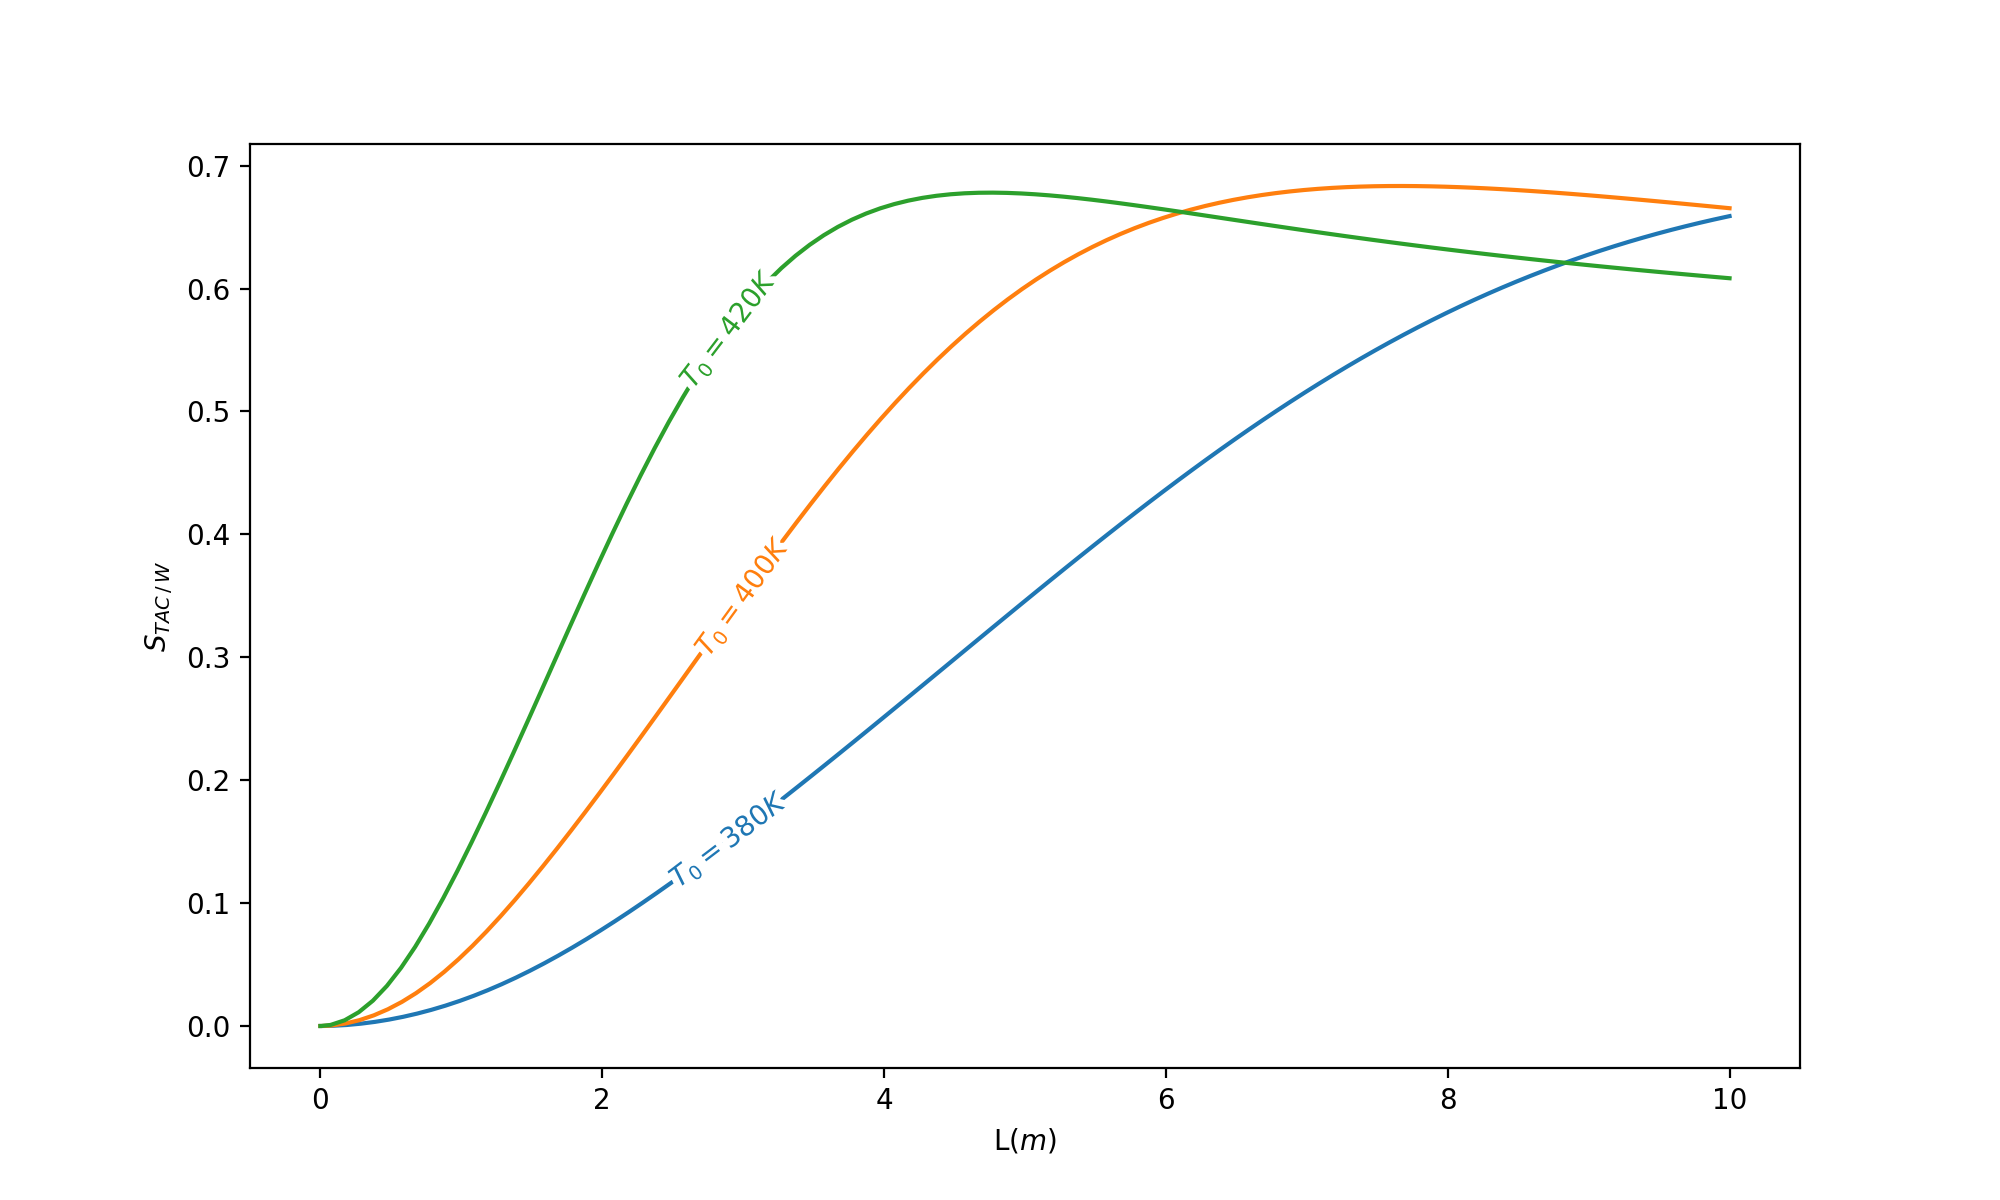

[Text(2.9, 0.15126191228812455, '$T_0=380K$'),
 Text(3.0, 0.34910183715231097, '$T_0=400K$'),
 Text(2.9, 0.5665744706786916, '$T_0=420K$')]

In [17]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

s_tac_W_380 = r380["TAC"] / r380["W"]
s_tac_W_400 = r400["TAC"] / r400["W"]
s_tac_W_420 = r420["TAC"] / r420["W"]

ax.set_ylabel("$S_{TAC\,/\,W}$")
ax.set_xlabel("L$(m)$")
s_tac_W_380.plot(ax=ax, legend=False, label="$T_0=380K$")
s_tac_W_400.plot(ax=ax, legend=False, label="$T_0=400K$")
s_tac_W_420.plot(ax=ax, legend=False, label="$T_0=420K$")
labelLines(ax.get_lines(), xvals=[2.9, 3.0, 2.9], yoffsets=[0, -0.002, -0.002])

<IPython.core.display.Javascript object>


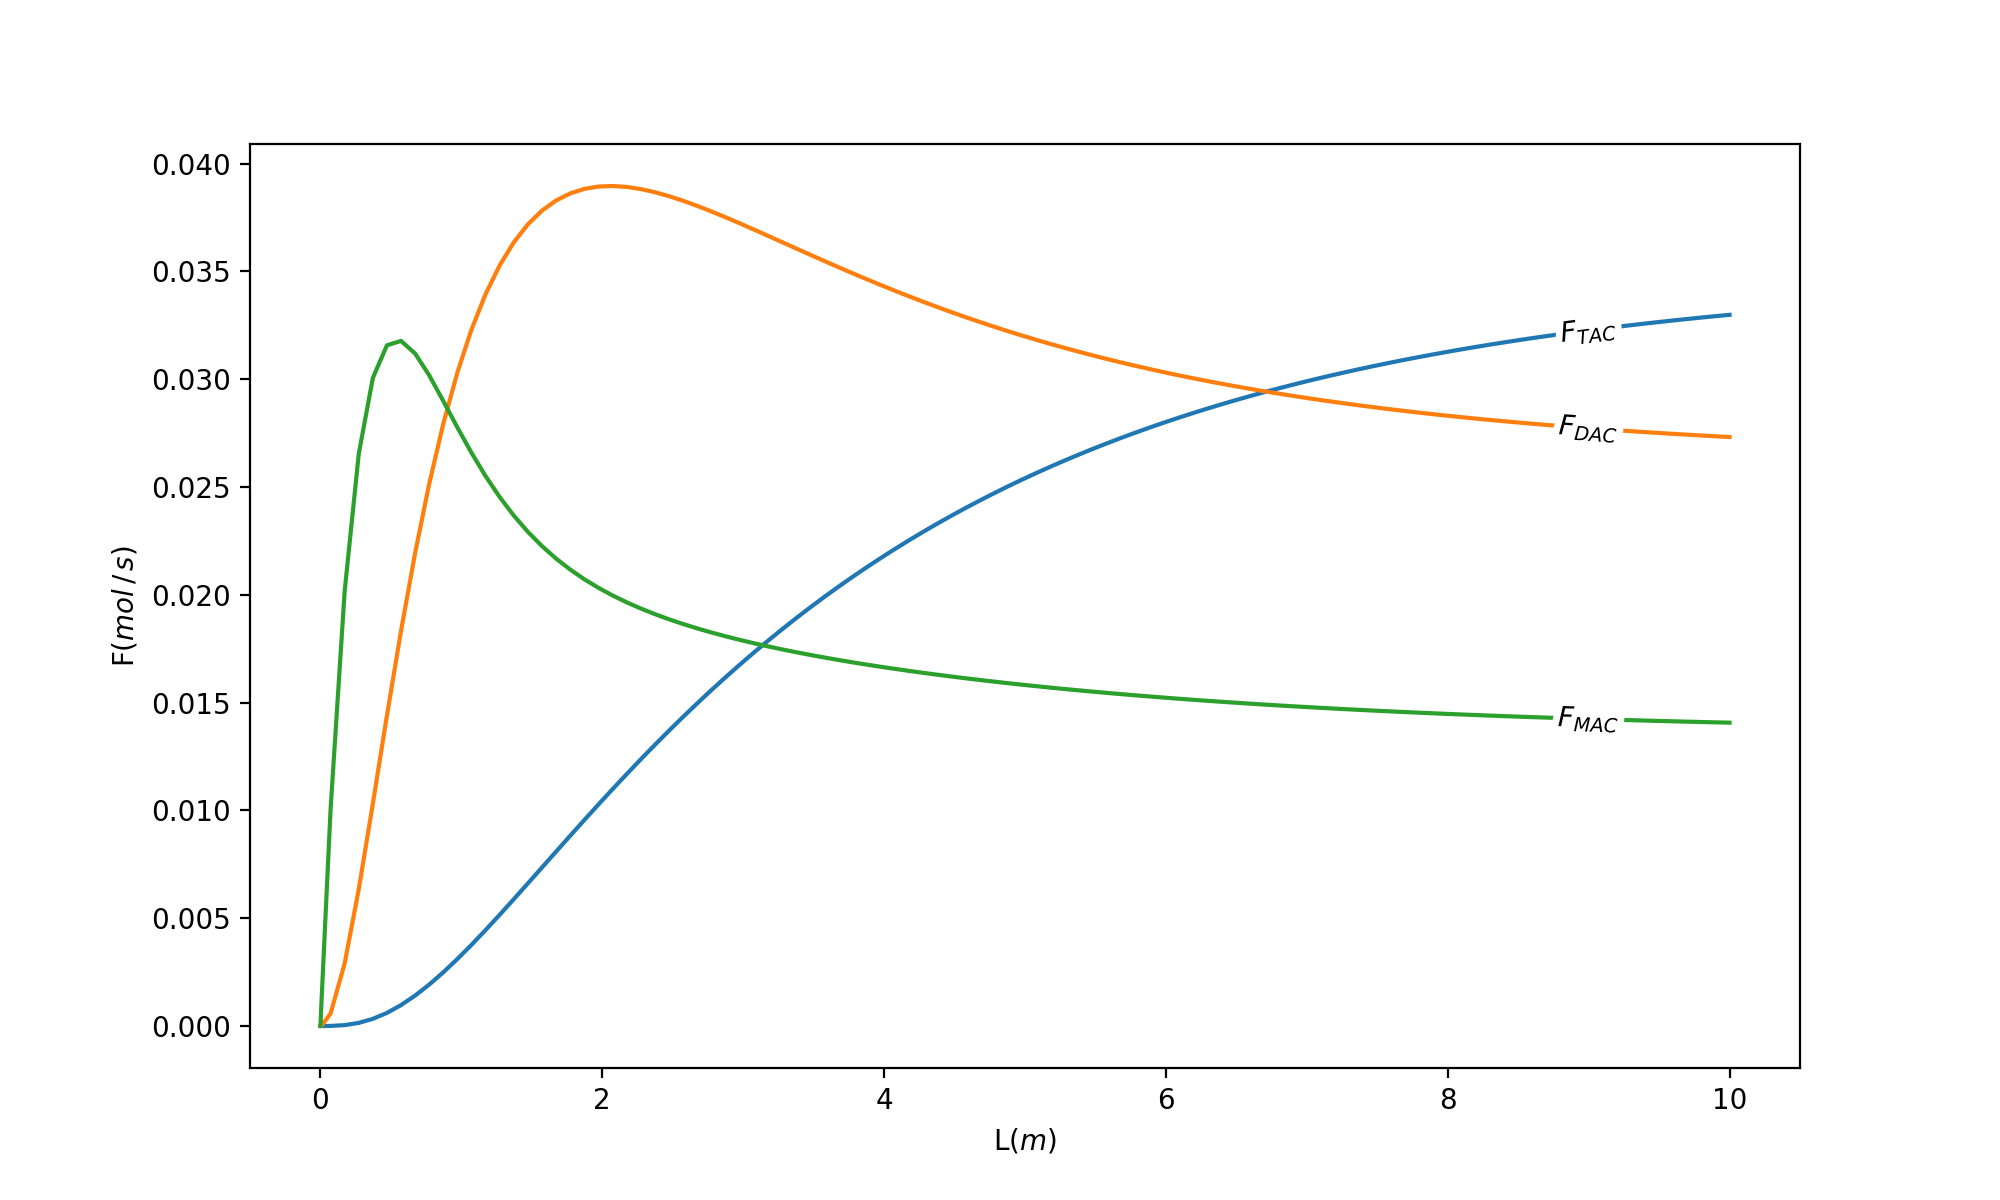

/Users/samsal/code/irq/env/lib/python3.9/site-packages/labellines/core.py:204: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=0.0, xmax=10.0, xval=15). Clipping it into the allowed range.
  warnings.warn(
/Users/samsal/code/irq/env/lib/python3.9/site-packages/labellines/core.py:204: UserWarning: The value at position 1 in `xvals` is outside the range of its associated line (xmin=0.0, xmax=10.0, xval=15). Clipping it into the allowed range.
  warnings.warn(
/Users/samsal/code/irq/env/lib/python3.9/site-packages/labellines/core.py:204: UserWarning: The value at position 2 in `xvals` is outside the range of its associated line (xmin=0.0, xmax=10.0, xval=15). Clipping it into the allowed range.
  warnings.warn(


[Text(9.0, 0.032262858660665715, '$F_{TAC}$'),
 Text(9.0, 0.027725986921937888, '$F_{DAC}$'),
 Text(9.0, 0.01424098325714203, '$F_{MAC}$')]

In [18]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

F_of_interest_380 = F380[["TAC", "DAC", "MAC"]]
F_of_interest_400 = F400[["TAC", "DAC", "MAC"]]
F_of_interest_420 = F420[["TAC", "DAC", "MAC"]]


ax.set_ylabel("F$(mol\,/\,s)$")
ax.set_xlabel("L$(m)$")

for column in F_of_interest_420.columns:
    F_of_interest_420[column].plot(ax=ax, legend=False, label=f"$F_{{{column}}}$", style="-")     

labelLines(ax.get_lines(), xvals=[15, 15, 15, ], color="k")

In [19]:
y_tac_gly_380 = F380.iloc[-1]["TAC"] / (F380.iloc[0]["GLY"] - F380.iloc[-1]["GLY"])
y_tac_gly_400 = F400.iloc[-1]["TAC"] / (F400.iloc[0]["GLY"] - F400.iloc[-1]["GLY"])
y_tac_gly_420 = F420.iloc[-1]["TAC"] / (F420.iloc[0]["GLY"] - F420.iloc[-1]["GLY"])

y = DataFrame(
    [[y_tac_gly_380, y_tac_gly_400, y_tac_gly_420]], 
    index=["Y TAC/GLY"], 
    columns=["To = 380", "To = 400", "To = 420"]
)

y

,To = 380,To = 400,To = 420
Y TAC/GLY,0.293863,0.400523,0.443519


In [20]:
yearly_production = 10000 * 1000 # kg / y
production = yearly_production * (1 / 365)  * (1 / 24) * (1 / 3600)
production = production * 1000 / substance_data["MW(g/mol)"]["TAC"]
production

1.4532183881115135

In [21]:
production_g = F420.iloc[-1]["TAC"] * substance_data["MW(g/mol)"]["TAC"]
production_g

7.197434833112369

In [22]:
n_tubes = production / F420.iloc[-1]["TAC"]
n_tubes

44.05707410907172

In [23]:
substance_data

,Cp(J/molK),Hf(J/mol),MW(g/mol),p(kg/m3)
Species,,,,
GLY,221.18,-669600.0,92.0938,1260.00
AAC,159.80,-483520.0,60.0520,1050.00
W,75.38,-285830.0,18.0153,997.77
TAC,389.00,-1330800.0,218.2039,1160.00
DAC,340.98,-1120700.0,176.1672,1170.00
MAC,291.36,-903530.0,134.1305,1200.00


In [24]:
_estimate_volumetric_flow([0.1, 1.6, 0, 0, 0, 0])

0.09881684126984128

In [25]:
np.sum(F420.iloc[-1])

1.700000000000001

In [26]:
F420.iloc[-1]

GLY    0.025629
AAC    1.432342
W      0.167658
TAC    0.032985
DAC    0.027317
MAC    0.014069
Name: 10.0, dtype: float64

In [27]:
F380.shape[0]

103